In [2]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 9.3 MB/s  eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rc('figure', figsize=(12.0, 6.0))

In [3]:
!pip install pycaret

In [4]:
from pycaret.classification import *

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
def converter(x):
    c, n = '', ''
    x = str(x).replace('.', '').replace('/','').replace(' ', '')
    for i in x:
        if i.isnumeric():
            n += i
        else :
            c += i 
    if n != '':
        return c, int(n)
    return c, np.nan

In [7]:
def create_extra_features(data):
    data['Ticket_type'] = data['Ticket'].map(lambda x: converter(x)[0])
    data['Ticket_number'] = data['Ticket'].map(lambda x: converter(x)[1])
    
    data['Cabin_type'] = data['Cabin'].map(lambda x: converter(x)[0])
    data['Cabin_number'] = data['Cabin'].map(lambda x: converter(x)[1])
    data['Name1'] = data['Name'].map(lambda x: x.split(', ')[0])    
    data['Name2'] = data['Name'].map(lambda x: x.split(', ')[1])
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['isAlone'] = data['FamilySize'].apply(lambda x : 1 if x == 1 else 0)
    
    # Sex
    data['Sex'] = data['Sex'].map({'male':0, 'female':1})
    
    # Age
    age_map = train[['Age', 'Pclass']].dropna().groupby('Pclass').median().to_dict()['Age']
    data.loc[train['Age'].isnull(), 'Age'] = data.loc[train['Age'].isnull(), 'Pclass'].map(age_map)

    # Embarked
    data['Embarked'] = data['Embarked'].fillna('X')
    return data

train = create_extra_features(train)
test = create_extra_features(test)

In [8]:
ce = CatBoostEncoder()

column_name = ['Ticket_type', 'Embarked', 'Cabin_type', 'Name1', 'Name2']
train[column_name] = ce.fit_transform(train[column_name], train['Survived'])
test[column_name] = ce.transform(test[column_name])

In [9]:
train.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [10]:
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
X = train.copy()
Y = test.copy()

In [12]:
X = X.fillna(X.median())
Y = Y.fillna(Y.median())

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('Survived', axis=1), X.Survived, test_size=0.2, random_state=0, stratify=X.Survived)

In [14]:
ada_clf = AdaBoostClassifier(n_estimators=30, learning_rate=0.1)
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
lgb_clf = lgb.LGBMClassifier()
gb_clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=3)
estimators = [('lr',lr_clf),('lgb',lgb_clf),('rf',rf_clf),('gb',gb_clf)]
voting_clf = VotingClassifier(estimators=estimators)
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=lgb.LGBMClassifier())

In [15]:
for name, clf in estimators+[('voting',voting_clf), ('stacking',stacking_clf)]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,
          accuracy_score(y_test, y_pred))

LogisticRegression 0.57225
LGBMClassifier 0.7826
RandomForestClassifier 0.77695
GradientBoostingClassifier 0.78325
VotingClassifier 0.7793
StackingClassifier 0.7824


In [21]:
pred_lgb = lgb_clf.predict(Y)

In [22]:
sample_submission['Survived'] = pred_lgb
sample_submission.to_csv(f'submission_lgb.csv',index=False)

In [23]:
pred_gb = gb_clf.predict(Y)

In [24]:
sample_submission['Survived'] = pred_gb
sample_submission.to_csv(f'submission_gb.csv',index=False)

In [25]:
pred_stacking = stacking_clf.predict(Y)

In [26]:
sample_submission['Survived'] = pred_stacking
sample_submission.to_csv(f'submission_stacking.csv',index=False)

### Simple Blending of public scores

In [30]:
lazy_sub = pd.read_csv('lazy_submission.csv')
light_auto = pd.read_csv('LightAutoML_multistart_composition_with_pseudo_LightAutoML.csv')
simple_catboost = pd.read_csv('simpleCatboost.csv')

In [31]:
total_result = (
    lazy_sub.Survived * 0.5
    + light_auto.Survived * 0.25
    + simple_catboost.Survived * 0.25
)
lazy_sub.Survived = np.where(total_result > 0.5, 1, 0)

In [32]:
lazy_sub.to_csv('lazy_submission.csv', index=False)

In [33]:
!kaggle competitions submit -c tabular-playground-series-apr-2021 -f lazy_submission.csv -m "Blending from public Kernel"

100%|████████████████████████████████████████| 879k/879k [00:00<00:00, 2.31MB/s]
Successfully submitted to Tabular Playground Series - Apr 2021

## PyCaret

In [29]:
setup(data = train, 
      target = 'Survived',
      numeric_imputation = 'median',
      fold=5,
      silent = True,
     )

,Description,Value
0,session_id,4155
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(100000, 16)"
5,Missing Values,True
6,Numeric Features,9
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


({'parameter': 'Hyperparameters',
  'auc': 'AUC',
  'confusion_matrix': 'Confusion Matrix',
  'threshold': 'Threshold',
  'pr': 'Precision Recall',
  'error': 'Prediction Error',
  'class_report': 'Class Report',
  'rfe': 'Feature Selection',
  'learning': 'Learning Curve',
  'manifold': 'Manifold Learning',
  'calibration': 'Calibration Curve',
  'vc': 'Validation Curve',
  'dimension': 'Dimensions',
  'feature': 'Feature Importance',
  'feature_all': 'Feature Importance (All)',
  'boundary': 'Decision Boundary',
  'lift': 'Lift Chart',
  'gain': 'Gain Chart',
  'tree': 'Decision Tree'},
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
 

In [30]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7816,0.8534,0.7310,0.7532,0.7419,0.5527,0.5529,1.1740
gbc,Gradient Boosting Classifier,0.7812,0.8527,0.7273,0.7545,0.7406,0.5516,0.5518,11.4800
ada,Ada Boost Classifier,0.7778,0.8457,0.7172,0.7535,0.7349,0.5438,0.5443,2.6520
xgboost,Extreme Gradient Boosting,0.7766,0.8484,0.7285,0.7457,0.7370,0.5429,0.5431,13.4800
ridge,Ridge Classifier,0.7749,0.0000,0.7095,0.7524,0.7303,0.5374,0.5381,0.1180
lda,Linear Discriminant Analysis,0.7749,0.8407,0.7103,0.7519,0.7305,0.5375,0.5381,0.3920
rf,Random Forest Classifier,0.7735,0.8448,0.7212,0.7437,0.7323,0.5361,0.5363,7.4360
et,Extra Trees Classifier,0.7682,0.8384,0.7166,0.7365,0.7264,0.5253,0.5255,5.0200
dt,Decision Tree Classifier,0.6854,0.6793,0.6354,0.6334,0.6344,0.3584,0.3584,0.7900
nb,Naive Bayes,0.6315,0.6572,0.3669,0.6202,0.4610,0.2082,0.2248,0.1000


In [31]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7837,0.8549,0.7358,0.7546,0.7451,0.5573,0.5574
1,0.7824,0.8551,0.7296,0.7555,0.7423,0.5541,0.5544
2,0.7796,0.8517,0.7241,0.7533,0.7384,0.5482,0.5485
3,0.7852,0.8560,0.7369,0.7567,0.7467,0.5603,0.5604
4,0.7770,0.8491,0.7286,0.7462,0.7373,0.5436,0.5437
Mean,0.7816,0.8534,0.7310,0.7532,0.7419,0.5527,0.5529
SD,0.0029,0.0026,0.0048,0.0037,0.0036,0.0061,0.0061


In [33]:
lightgbm = tune_model(lightgbm
#                      ,num_iter=100
                     , optimize='AUC' 
                     )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7827,0.8543,0.7369,0.7522,0.7445,0.5555,0.5556
1,0.7830,0.8552,0.7314,0.7555,0.7433,0.5554,0.5557
2,0.7801,0.8519,0.7278,0.7523,0.7398,0.5496,0.5498
3,0.7851,0.8565,0.7364,0.7568,0.7465,0.5601,0.5603
4,0.7762,0.8481,0.7298,0.7442,0.7369,0.5422,0.5423
Mean,0.7814,0.8532,0.7325,0.7522,0.7422,0.5526,0.5527
SD,0.0031,0.0030,0.0036,0.0044,0.0034,0.0062,0.0062


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


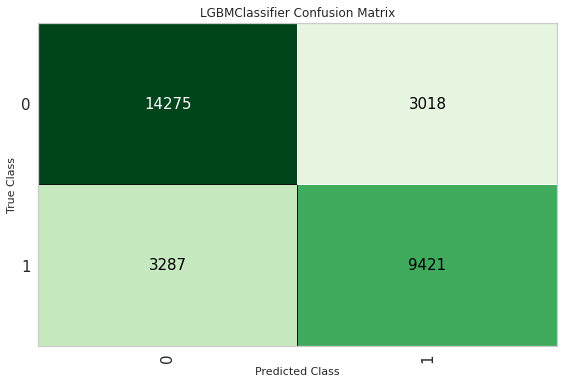

In [34]:
plot_model(lightgbm, plot = 'confusion_matrix')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


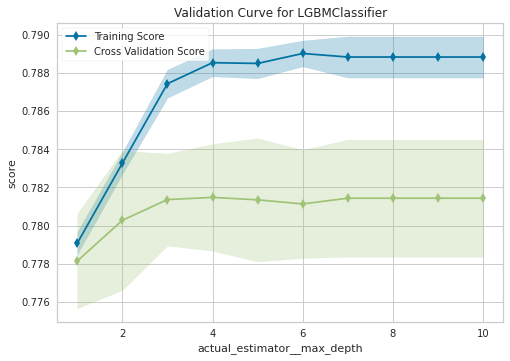

In [35]:
plot_model(lightgbm, plot = 'vc')

In [ ]:
plot_model(lightgbm, plot = 'feature_all')

In [ ]:
plot_model(lightgbm, plot = 'auc')

In [ ]:
plot_model(lightgbm, plot = 'boundary')

In [ ]:
predictions = predict_model(lightgbm, data = test)
sample_submission['Survived'] = predictions['Label']
sample_submission.to_csv(f'submission.csv',index=False)